In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import decomposition
from sklearn import cluster
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE

from skimage.transform import rescale
from scipy import ndimage as ndi

matplotlib.style.use('fivethirtyeight')

[970, 957, 600, 346, 138, 766, 77, 549, 957, 852, 678, 948, 905, 437, 71, 685, 189, 984, 390, 679, 505, 290, 203, 666, 160, 672, 970, 120]
[1554, 1536, 954, 568, 245, 1231, 134, 876, 1536, 1366, 1083, 1521, 1454, 717, 124, 1094, 328, 1574, 641, 1085, 815, 478, 345, 1056, 280, 1072, 1554, 216]


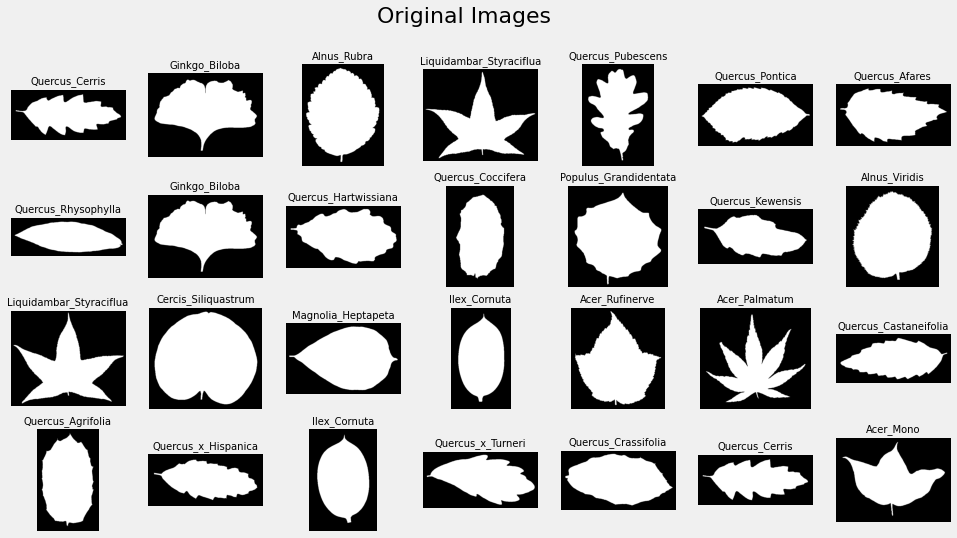

In [14]:
matplotlib.style.use('fivethirtyeight')

## 데이터 로딩
dataDir   = './data/' # 경로 지정
trainData = pd.read_csv(dataDir + 'train.csv') # csv 데이터를 pandas 패키지로 읽어옴
classEncoder = LabelEncoder() # LabelEncoder 함수를 사용하기 쉽게 저장
trainLabels  = classEncoder.fit_transform(trainData.loc[:,'species']) # by using LabelEncoder, encode spceies column
trainIDs     = np.array(trainData.loc[:,'id']) # save the IDs

# show some random images
plt.figure(figsize=(15,8)) # set window size
plt.suptitle('Original Images', fontsize=22) # set title
rndIdx = []
rndIDs = []
for k in range(28):
    curIdx = np.random.randint(len(trainIDs))
    rndIdx.append(curIdx)
    curID = trainIDs[curIdx]
    rndIDs.append(curID)

print(rndIdx)
print(rndIDs)

for k in range(28):
    imageFilename = dataDir + 'images/' + str(rndIDs[k]) + '.jpg' # load random image filename = images/${id}.jpg
    plt.subplot(4,7,k+1) # use 4*7 matrix, and (k+1)th index
    plt.imshow(mpimg.imread(imageFilename), cmap='gray') # show read image
    plt.title(classEncoder.classes_[trainLabels[rndIdx[k]]], fontsize=10) # set title
    plt.axis('off') # turn off the axit

max:  [1089. 1706.] & min:  [189. 159.]
[[ 467.  251.  456. ...  845.  234.  377.]
 [ 526.  667.  691. ... 1202. 1295.  710.]]
1009.0 700.0
rndIdx:  [970, 957, 600, 346, 138, 766, 77, 549, 957, 852, 678, 948, 905, 437, 71, 685, 189, 984, 390, 679, 505, 290, 203, 666, 160, 672, 970, 120]


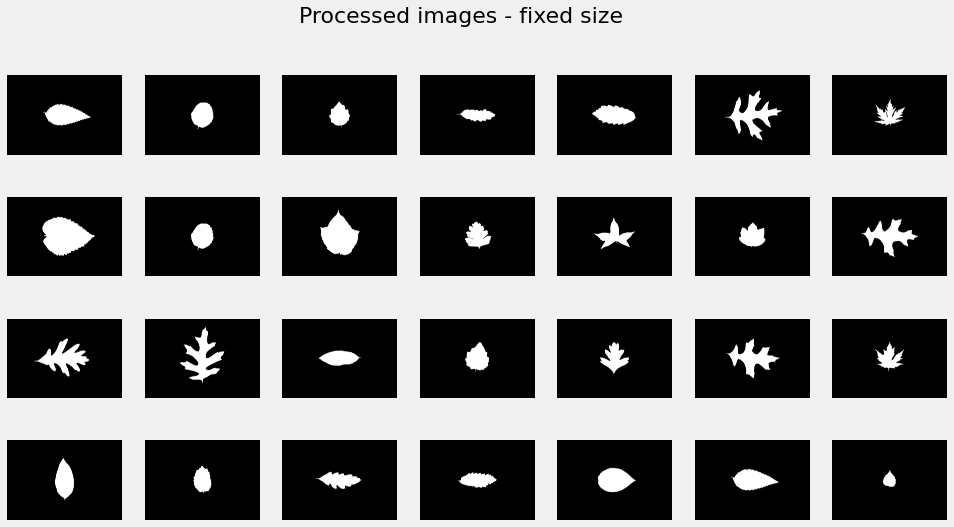

In [15]:
# preprocessing : fit the images
numImages = 1584

# load all images to an array
shapesMatrix = np.zeros((2, numImages)) # 2 by 1584 zeros matrix
listOfImages = []
for idx in range(numImages):
    imageFilename = dataDir + "images/" + str(idx+1) + ".jpg" # set filename
    curImg = mpimg.imread(imageFilename) # read the image with filename
    shapesMatrix[:, idx] = np.shape(curImg) # get width, height
    listOfImages.append(curImg) # save the width height info

# calculate the shape of an image
maxShapeSize = shapesMatrix.max(axis=1) # get max size of width, height
minShapeSize = shapesMatrix.min(axis=1) # get min size of widht, height. Just for checking
print("max: ", maxShapeSize, "& min: ", minShapeSize)
for idx in range(len(maxShapeSize)):
    if maxShapeSize[idx] % 2 == 0:
        maxShapeSize[idx] += 311 # if a element of maxShapeSize is an even, add 311
        # it can be also += 147
    else:
        maxShapeSize[idx] += 310 # if a element of maxShapeSize is an odd, add 310
        # it can be also += 222

# place all original images at the center
print(shapesMatrix)
fullImageMatrix3D = np.zeros(np.hstack((maxShapeSize, np.shape(shapesMatrix[1]))).astype(int), dtype=np.dtype('u1'))
# create new zero-filled array that 
# dtype u1 == unsigned-8bit inteaager
destXc = (maxShapeSize[1]+1)/2 # set destXc is center of maxShape width
destYc = (maxShapeSize[0]+1)/2 # set destYc is center of maxShape height
print(destXc, destYc) # check destXc, destYc

for idx, curImg in enumerate(listOfImages):
    Yc, Xc = ndi.center_of_mass(curImg) # calculate center of each image
    Xd = destXc - Xc # x-axis difference of both center
    Yd = destYc - Yc # y-axis difference of both center
    if (Xd <= 0) or (Yd <= 0): print("original center: ", Xc, Yc, "&& fixed center: ", Xd, Yd) # error handling
    rowIndLims = (int(round(Yd)), int(round(Yd)+np.shape(curImg)[0])) # yd to yd + height = newPosition_y
    colIndLims = (int(round(Xd)), int(round(Xd)+np.shape(curImg)[1])) # xd to xd + width = newPosition_x
    fullImageMatrix3D[rowIndLims[0]:rowIndLims[1], colIndLims[0]:colIndLims[1], idx] = curImg # centerize

# show all fixed images
print("rndIdx: ", rndIdx)
plt.figure(figsize=(15, 8))
plt.suptitle("Processed images - fixed size", fontsize=22)
plt.imshow(fullImageMatrix3D[:, :, 0], cmap="gray")
for idx in range(28):
    # randInd = np.random.randint(np.shape(fullImageMatrix3D)[2])
    plt.subplot(4, 7, idx+1)
    plt.imshow(fullImageMatrix3D[:, :, rndIdx[idx]], cmap="gray")
    plt.axis("off")

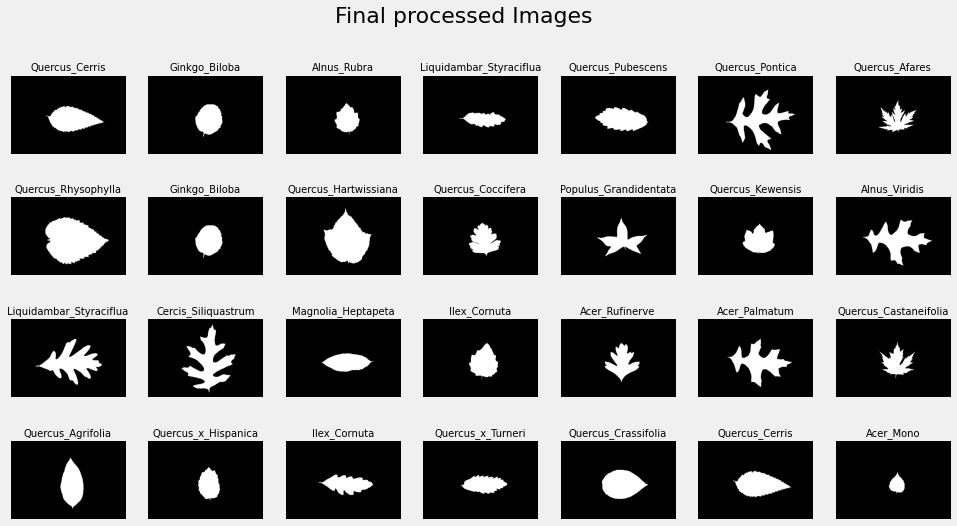

In [16]:
# re-crop images for don't have zeros in them in any image
xValid = fullImageMatrix3D.mean(axis=2).sum(axis=0) > 0
yValid = fullImageMatrix3D.mean(axis=2).sum(axis=1) > 0
xLims  = (np.nonzero(xValid)[0][0], np.nonzero(xValid)[0][-1])
yLims  = (np.nonzero(yValid)[0][0], np.nonzero(yValid)[0][-1])
fullImageMatrix3D = fullImageMatrix3D[yLims[0]:yLims[1], xLims[0]:xLims[1], :]

plt.figure(figsize=(15, 8))
plt.suptitle("Final processed Images", fontsize=22)
for idx in range(28):
    # randIdx = np.random.randint(np.shape(fullImageMatrix3D)[2])
    plt.subplot(4, 7, idx+1)
    plt.imshow(fullImageMatrix3D[:, :, rndIdx[idx]], cmap="gray")
    plt.axis("off")
    if rndIdx[idx] < len(trainLabels) :
        plt.title(classEncoder.classes_[trainLabels[rndIdx[idx]]], fontsize = 10)
    else :
        plt.title("test data sample", fontsize=10)

# scale down the images
rescaleFactor = 0.15

scaledDownImage = rescale(fullImageMatrix3D[:, :, 0], rescaleFactor)
scaledDownImages = np.zeros(np.hstack((np.shape(scaledDownImage), np.shape(fullImageMatrix3D)[2])), dtype=np.dtype('f4'))

for imIdx in range(np.shape(fullImageMatrix3D)[2]):
    scaledDownImages[:, :, imIdx] = rescale(fullImageMatrix3D[:, :, imIdx], rescaleFactor)

del fullImageMatrix3D

In [29]:
class KmeansModel:

    def __init__(self, X, numClusters=10, objectPixels=None):
        '''
        inputs: 
            X                       - numSamples * numDimentions matrix
            numClusters             - number of clusters to use
            objectPixels (optional) - an binnary mask image used for presentation
        '''
        numDataSamples = X.shape[0]
        self.numClusters = numClusters        
        if objectPixels is None:
            self.objectPixels = np.ones((1,X.shape[1]),dtype=np.bool)
        else:
            self.objectPixels = objectPixels
        assert(self.objectPixels.ravel().sum() == X.shape[1])

        KmeansModel = cluster.KMeans(n_clusters=numClusters, n_init=5)
        self.dataRepresentation = KmeansModel.fit_transform(X)
        self.KmeansModel = KmeansModel
        
        # calculate cluster frequency
        clusterInds = KmeansModel.labels_
        clusterFrequency = []
        for clusterInd in range(numClusters):
            clusterFrequency.append((clusterInds == clusterInd).sum()/float(numDataSamples))
        self.clusterFrequency = np.array(clusterFrequency)
        self.sortedTemplatesByFrequency = np.flipud(np.argsort(clusterFrequency))

    def RepresentUsingModel(self, X, representationMethod='distFromAllClusters'):
        
        if representationMethod == 'distFromAllClusters':
            return self.KmeansModel.transform(X)
        if representationMethod == 'clusterIndex':
            return self.KmeansModel.predict(X)
        if representationMethod == 'oneHotClusterIndex':
            clusterAssignment = self.KmeansModel.predict(X)
            X_transformed = np.zeros((X.shape[0],self.numClusters))
            for sample in range(X.shape[0]):
                X_transformed[sample,clusterAssignment[sample]] = 1
            return X_transformed

    def ReconstructUsingModel(self, X_transformed, representationMethod='distFromAllClusters'):

        if representationMethod == 'clusterIndex':
            clusterAssignment = X_transformed
        if representationMethod == 'oneHotClusterIndex':
            clusterAssignment = np.argmax(X_transformed,axis=1)
        if representationMethod == 'distFromAllClusters':
            clusterAssignment = np.argmin(X_transformed,axis=1)

        X_reconstructed = np.zeros((X_transformed.shape[0],self.KmeansModel.cluster_centers_.shape[1]))
        for sample in range(X_transformed.shape[0]):
            X_reconstructed[sample,:] = self.KmeansModel.cluster_centers_[clusterAssignment[sample],:]
                
        return X_reconstructed
        
    def InterpretUsingModel(self, X, representationMethod='clusterIndex'):
        return self.ReconstructUsingModel(\
                        self.RepresentUsingModel(X,representationMethod),representationMethod)

    # shows the cluster centers
    def ShowTemplates(self, numTemplatesToShow=16):
        print("in show templates")
        numTemplatesToShow = min(numTemplatesToShow, self.numClusters)
        
        numFigRows = int(np.ceil(np.sqrt(numTemplatesToShow)));
        numFigCols = int(np.ceil(np.sqrt(numTemplatesToShow)));
        numTemplatesPerFigure = int(numFigRows*numFigCols)
        numFigures = int(np.ceil(float(numTemplatesToShow)/numTemplatesPerFigure))
                
        for figureInd in range(numFigures):
            plt.figure()
            for plotInd in range(numTemplatesPerFigure):
                templateInd = self.sortedTemplatesByFrequency[numTemplatesPerFigure*figureInd + plotInd]
                if templateInd >= self.numClusters:
                    break
                templateImage = np.zeros(np.shape(self.objectPixels))
                templateImage[self.objectPixels] = \
                        self.KmeansModel.cluster_centers_[templateInd,:].ravel()

                plt.subplot(numFigRows,numFigCols,plotInd+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(templateImage)
                else:
                    plt.imshow(templateImage,cmap='hot'); plt.axis('off')
                plt.title(str(100*self.clusterFrequency[templateInd])[:4] + "% frequency");
            plt.tight_layout()
            
    # shows several random model reconstructions
    def ShowReconstructions(self, X, numReconstructions=6):
        assert(np.shape(X)[1] == self.objectPixels.ravel().sum())
        numSamples = np.shape(X)[0]
        numReconstructions = min(numReconstructions, numSamples)
        
        originalImage      = np.zeros(np.shape(self.objectPixels))
        reconstructedImage = np.zeros(np.shape(self.objectPixels))
        
        numReconstructionsPerFigure = min(6, numReconstructions)
        numFigures = int(np.ceil(float(numReconstructions)/numReconstructionsPerFigure))
        
        for figureInd in range(numFigures):
            plt.figure()
            for plotCol in range(numReconstructionsPerFigure):
                dataSampleInd = np.random.randint(numSamples)
                originalImage[self.objectPixels] = X[dataSampleInd,:].ravel()
                reconstructedImage[self.objectPixels] = \
                        self.InterpretUsingModel(np.reshape(X[dataSampleInd,:],[1,-1])).ravel()
                diffImage = abs(originalImage - reconstructedImage)
                
                # original image
                plt.subplot(3,numReconstructionsPerFigure,0*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(originalImage); plt.title('original signal')
                else:
                    plt.imshow(originalImage, cmap='gray'); 
                    plt.title('original image'); plt.axis('off')
                    
                # reconstred image
                plt.subplot(3,numReconstructionsPerFigure,1*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(reconstructedImage); plt.title('reconstructed signal')
                else:
                    plt.imshow(reconstructedImage, cmap='gray'); 
                    plt.title('reconstructed image'); plt.axis('off')

                # diff image
                plt.subplot(3,numReconstructionsPerFigure,2*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(diffImage); plt.title('abs difference signal')
                else:
                    plt.imshow(diffImage, cmap='gray'); 
                    plt.title('abs difference image'); plt.axis('off')
            plt.tight_layout()


    # shows distrbution along the distance from a particular cluster and several examples for that distance
    def ShowSingleTemplateDistances(self, X, listOfTemplates=[0,1]):

        showAsTraces = (np.shape(self.objectPixels)[0] == 1)
        assert(all([(x in range(self.numClusters)) for x in listOfTemplates]))
                
        X_rep = self.RepresentUsingModel(X, representationMethod='distFromAllClusters')
        
        percentilesToShow = [1,5,10,30,60,99]
        numReadDataSamplePerPercentile = 4
        representationPercentiles = []
        for percentile in percentilesToShow:
            representationPercentiles.append(np.percentile(self.dataRepresentation, percentile, axis=0))
        medianRepVec =  np.percentile(self.dataRepresentation, 50, axis=0)

        for templateInd in listOfTemplates:
            plt.figure(); gs = gridspec.GridSpec(numReadDataSamplePerPercentile+2,
                                                 len(percentilesToShow))

            # calculate the Gaussian smoothed distribution of values along the eignevector direction
            sigmaOfKDE = (representationPercentiles[-1][templateInd] - 
                          representationPercentiles[1][templateInd])/100.0
            pdfStart   = representationPercentiles[1][templateInd]  - 15*sigmaOfKDE
            pdfStop    = representationPercentiles[-1][templateInd] + 15*sigmaOfKDE
            xAxis = np.linspace(pdfStart,pdfStop,200)
            PDF_Model = KernelDensity(kernel='gaussian', \
                            bandwidth=sigmaOfKDE).fit(self.dataRepresentation[:,templateInd].reshape(-1,1))
            logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))
            percentileValuesToShow = \
                [representationPercentiles[x][templateInd] for x in range(len(representationPercentiles))]
            percentilesToShowLogPDF = \
                PDF_Model.score_samples(np.array(percentileValuesToShow).reshape(-1,1))

            # show distribution of distance from current template and red dots at the list of precentiles to show 
            plt.subplot(gs[0,:])
            plt.fill(xAxis, np.exp(logPDF), fc='b', alpha=0.9);
            plt.scatter(percentileValuesToShow, np.exp(percentilesToShowLogPDF), c='r',s=40);
            plt.title(str(100*self.clusterFrequency[templateInd])[:4] + '% assignment frequency');

            for plotCol, currPrecentile in enumerate(percentilesToShow):                
                currPrecentileRepVec              = medianRepVec.copy()
                currPrecentileRepVec[templateInd] = representationPercentiles[plotCol][templateInd]
                
                currPrecentileImage = np.zeros(np.shape(self.objectPixels))
                currPrecentileRepVec = currPrecentileRepVec[:,np.newaxis].T
                currPrecentileImage[self.objectPixels] = \
                            self.ReconstructUsingModel(currPrecentileRepVec).ravel()
                
                # show the median image with current precentile as activation of the curr image
                plt.subplot(gs[1,plotCol]);
                if showAsTraces:
                    plt.plot(currPrecentileImage); 
                    plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%')
                else:
                    plt.imshow(currPrecentileImage, cmap='hot'); 
                    plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%'); plt.axis('off')

                # find the most suitible candidates in X for current precentile
                distFromPercentile = abs(X_rep[:,templateInd] - 
                                         representationPercentiles[plotCol][templateInd])
                X_inds = np.argpartition(distFromPercentile, \
                                         numReadDataSamplePerPercentile)[:numReadDataSamplePerPercentile]
                for k, X_ind in enumerate(X_inds):
                    currNearestPrecentileImage = np.zeros(np.shape(self.objectPixels))
                    currNearestPrecentileImage[self.objectPixels]  = X[X_ind,:].ravel()
                    
                    plt.subplot(gs[2+k,plotCol]);
                    if showAsTraces:
                        plt.plot(currNearestPrecentileImage); 
                        plt.title('NN with closest percentile');
                    else:
                        plt.imshow(currNearestPrecentileImage, cmap='gray'); 
                        plt.title('NN with closest percentile'); plt.axis('off')
            plt.tight_layout()
            
            
    def ShowDataScatterPlotsWithTSNE(self, X=None, y=None, tSNE_perplexity=30.0, colorMap='Paired'):
        # show the distance from 2 most frequent clusters and the tSNE of the entire "distance form template" space 
        
        if X is None:
            X_rep = self.dataRepresentation
        else:
            X_rep = self.RepresentUsingModel(X)
            
        if y is None:
            y = np.ones(X_rep.shape[0])
            
        tSNE_KmeansModel = TSNE(n_components=2, perplexity=tSNE_perplexity, random_state=0)
        X_rep_tSNE = tSNE_KmeansModel.fit_transform(X_rep)
        
        # take the two most frequent patterns
        mostFrequent = self.sortedTemplatesByFrequency[:2]
        
        plt.figure()
        plt.subplot(1,2,1); 
        plt.scatter(X_rep[:,mostFrequent[0]], \
                    X_rep[:,mostFrequent[1]],c=y,cmap=colorMap,s=10,alpha=0.9)
        plt.title('"distance from template" representation'); 
        plt.xlabel('distance from template 1'); plt.ylabel('distance from template 2')
        plt.subplot(1,2,2); 
        plt.scatter(X_rep_tSNE[:,0],X_rep_tSNE[:,1],c=y,cmap=colorMap,s=15,alpha=0.9)
        plt.title('t-SNE of Kmeans representation'); plt.xlabel('t-SNE axis1'); plt.ylabel('t-SNE axis2')


    def ShowTemplatesInPCASpace(self, X, y=None, tSNE_perplexity=30.0, colorMap='Paired'):
        # show the templates in the 2PC space and the tSNE of the entire PCA space
        
        # build PCA model and project the data onto the PCA space
        PCAModel = decomposition.PCA(n_components=60, whiten=False)
        X_rep = PCAModel.fit_transform(X)
                
        # project the Kmeans templates onto the PCA space
        templates_rep = PCAModel.transform(templateModel.KmeansModel.cluster_centers_)
        
        if y is None:
            y = self.RepresentUsingModel(X, representationMethod='clusterIndex')
            
        tSNE_PCAModel = TSNE(n_components=2, perplexity=tSNE_perplexity, random_state=0)
        X_rep_tSNE = tSNE_PCAModel.fit_transform(np.vstack((X_rep,templates_rep))) 
        
        plt.figure()
        plt.subplot(1,2,1); plt.scatter(X_rep[:,0],X_rep[:,1],c=y,cmap=colorMap,s=15,alpha=0.9)
        plt.scatter(templates_rep[:,0],templates_rep[:,1],c='k',cmap=colorMap,s=50)
        plt.title('PCA representation'); plt.xlabel('PC1 coeff'); plt.ylabel('PC2 coeff')
        
        nC = templates_rep.shape[0]        
        plt.subplot(1,2,2); 
        plt.scatter(X_rep_tSNE[:-nC,0],\
                    X_rep_tSNE[:-nC,1],c=y,cmap=colorMap,s=15,alpha=0.9)
        plt.scatter(X_rep_tSNE[-nC:,0],\
                    X_rep_tSNE[-nC:,1],c='k',cmap=colorMap,s=50)
        plt.title('t-SNE of PCA representation'); plt.xlabel('t-SNE axis1'); plt.ylabel('t-SNE axis2')

/Users/hajun/Documents/workspaces/univ/k-means/k_means/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hajun/Documents/workspaces/univ/k-means/k_means/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


in show templates


/Users/hajun/Documents/workspaces/univ/k-means/k_means/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hajun/Documents/workspaces/univ/k-means/k_means/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


in show templates


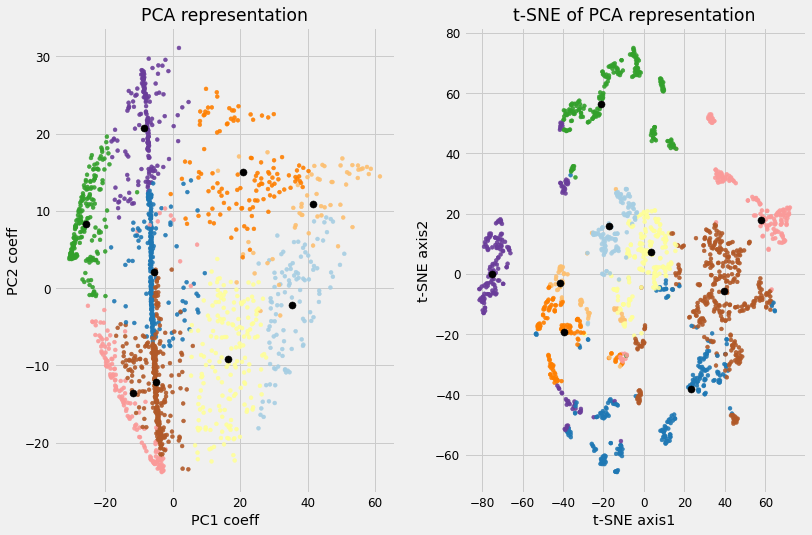

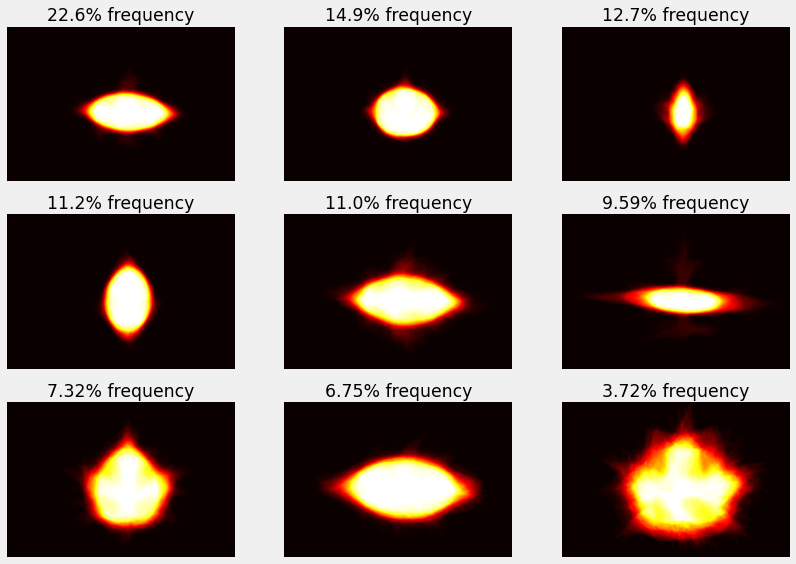

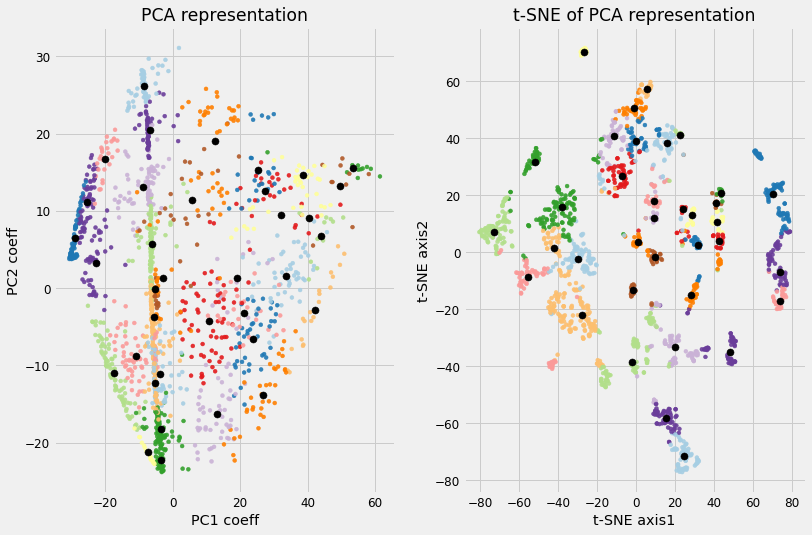

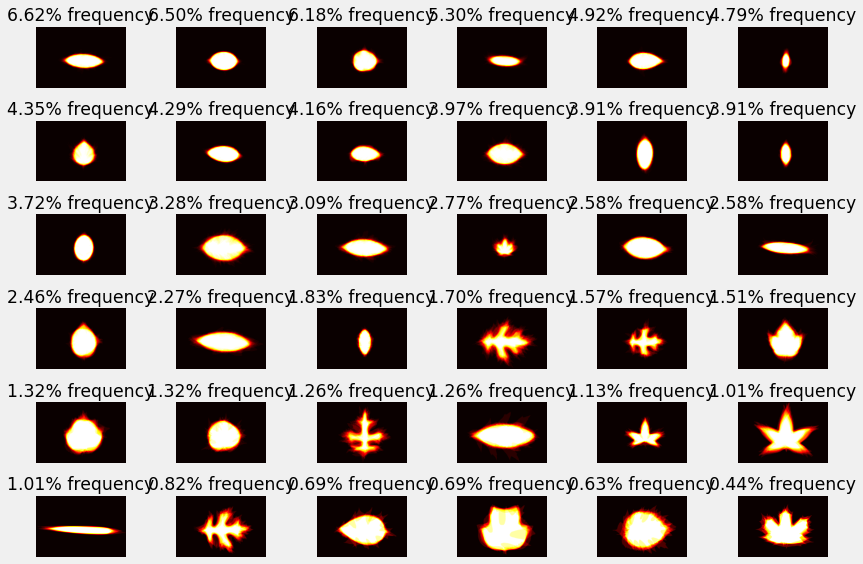

In [18]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,9)

objectPixels = np.ones((np.shape(scaledDownImages)[0],np.shape(scaledDownImages)[1])) == 1
sampleDim = np.shape(scaledDownImages)[0]*np.shape(scaledDownImages)[1]
X = scaledDownImages.reshape(sampleDim,-1).T

# Cluster Num = 9
numClusters = 9
templateModel = KmeansModel(X, numClusters, objectPixels=objectPixels)

# See the scatter
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,8)

templateModel.ShowTemplatesInPCASpace(X, y=None, tSNE_perplexity=15.0, colorMap='Paired')

# See the result of clustering
templateModel.ShowTemplates(numTemplatesToShow=numClusters)

# Cluster Num = 36
numClusters = 36
templateModel = KmeansModel(X, numClusters, objectPixels=objectPixels)

# See the scatter
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,8)

templateModel.ShowTemplatesInPCASpace(X, y=None, tSNE_perplexity=15.0, colorMap='Paired')

# See the result of clustering
templateModel.ShowTemplates(numTemplatesToShow=numClusters)

/Users/hajun/Documents/workspaces/univ/k-means/k_means/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hajun/Documents/workspaces/univ/k-means/k_means/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


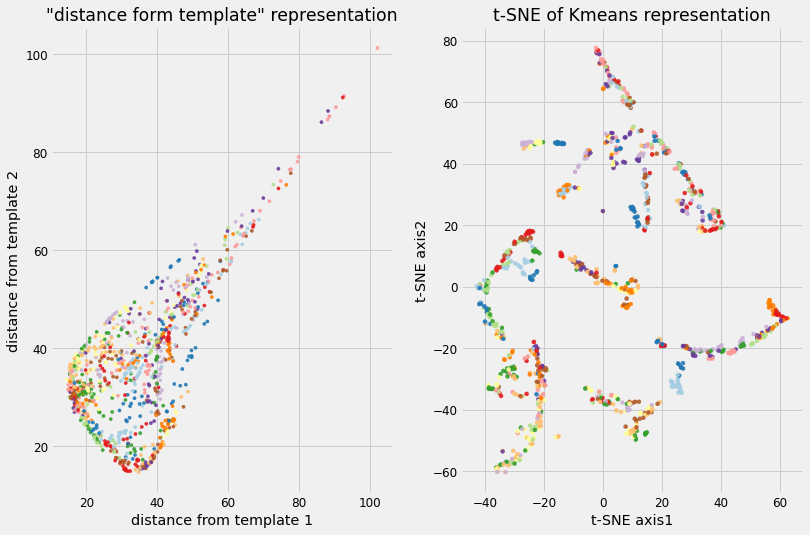

In [30]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,8)

X_train = X[trainIDs-1,:]
y_train = trainLabels

templateModel.ShowDataScatterPlotsWithTSNE(X=X_train, y=y_train, tSNE_perplexity=15.0, colorMap='Paired')